## Simple UNET

In [1]:
import torch
from torch import nn
from typing import override
from einops import rearrange

- 먼저 Convolution을 해주는 SubModule을 정의하자.

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
    
    @override
    def forward(self, x):
        return self.convs(x)

- random vector로 test 해본다.

In [3]:
test = ConvBlock(3, 64)
x = torch.randn(1, 3, 32, 32)
print(test(x).shape) 

torch.Size([1, 64, 32, 32])


- 그다음, ConvBlock을 하위 모듈로 가지는 Unet을 설계한다.

In [4]:
class UNet(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()

        self.down1 = ConvBlock(in_ch, 64)
        self.down2 = ConvBlock(64, 128)
        self.bot1 = ConvBlock(128, 256)
        self.up2 = ConvBlock(128 + 256, 128)
        self.up1 = ConvBlock(128 + 64, 64)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
    
    @override
    def forward(self, x):
        x1 = self.down1(x)              # (b, 64, H, W)
        x = self.maxpool(x1)            # (b, 64, H/2, W/2)
        x2 = self.down2(x)              # (b, 128, H/2, W/2)
        x = self.maxpool(x2)            # (b, 128, H/4, W/4)
        x = self.bot1(x)                # (b, 256, H/4, W/4)
        x = self.upsample(x)            # (b, 256, H/2, W/2)
        x = torch.cat([x, x2], dim=1)   # (b, 128 + 256, H/2, W/2)
        x = self.up2(x)                 # (b, 128, H/2, W/2)
        x = self.upsample(x)            # (b, 128, H, W)
        x = torch.cat([x, x1], dim=1)   # (b, 128 + 64, H, W)
        x = self.up1(x)                 # (b, 64, H, W)
        x = self.out(x)                 # (b, 1, H, W)
        return x

- 다시 random vector로 test를 진행해본다.

In [5]:
test = UNet().cuda()
x = torch.randn(1, 1, 28, 28).cuda()
print(test(x).shape)

torch.Size([1, 1, 28, 28])


#### Positional Encoding

In [6]:
import torch

def _pos_encoding(t, output_dim, device="cpu"):
    D = output_dim
    v = torch.zeros(D, device=device)
    i = torch.arange(0, D, device=device)
    div_term = 10000 ** (i / D)
    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[0::2])
    return v

def pos_encoding(ts, output_dim, device="cpu"):
    batch_size = len(ts)
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(ts[i], output_dim, device)
    return v

- Positional Encoding에 관한 자세한 내용은 "Attention Is All You Need(2017)"를 참고하세요.

In [7]:
v = pos_encoding(torch.arange(100), 256)
print(v.shape)

torch.Size([100, 256])


#### PosEncoding - Visualization

<Figure size 640x480 with 0 Axes>

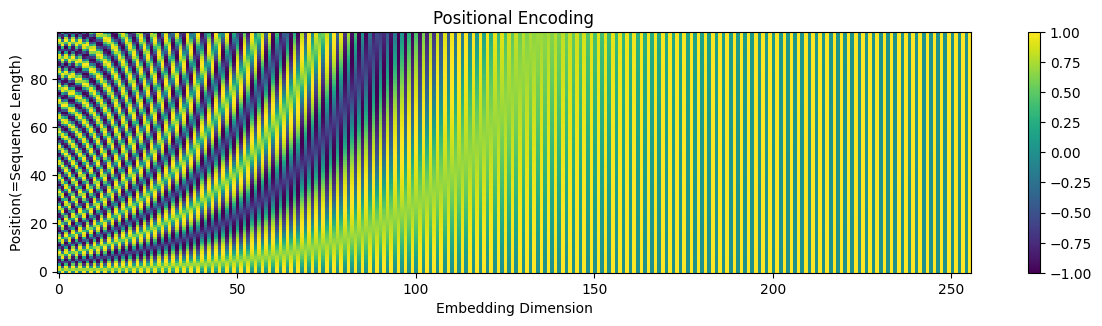

In [8]:
import numpy as np
import matplotlib.pyplot as plt

v = v.detach().cpu().numpy()
plt.clf()
plt.style.use("default")
fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow(v, aspect="auto", origin="lower", interpolation="none")
fig.canvas.draw()
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.title("Positional Encoding")
plt.xlabel("Embedding Dimension")
plt.ylabel("Position(=Sequence Length)")
plt.show()

## ConvBlock with Positional Encoding

- convolution block에 위치 인코딩 입력을 추가로 받을 수 있도록 개조한다.

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )
    
    @override
    def forward(self, x, v):
        v = self.mlp(v)
        v = rearrange(v, 'N C -> N C 1 1')
        y = self.convs(x + v)
        return y

- test를 해보자.

In [10]:
block = ConvBlock(3, 64, 256)
x = torch.randn(1, 3, 32, 32) # (b, c, h, w)
v = torch.randn(1, 256) # (b, time_embed_dim)
print(block(x, v).shape)

torch.Size([1, 64, 32, 32])


## UNET with Pos-Encoding

In [11]:
class UNet(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100):
        super().__init__()

        self.time_embed_dim = time_embed_dim
        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(64 + 128, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
    
    @override
    def forward(self, x, timesteps):
        v = pos_encoding(timesteps, self.time_embed_dim, x.device)

        x1 = self.down1(x, v)           # (b, 64, H, W)
        x = self.maxpool(x1)            # (b, 64, H/2, W/2)
        x2 = self.down2(x, v)           # (b, 128, H/2, W/2)
        x = self.maxpool(x2)            # (b, 128, H/4, W/4)

        x = self.bot1(x, v)             # (b, 256, H/4, W/4)

        x = self.upsample(x)            # (b, 256, H/2, W/2)
        x = torch.cat([x, x2], dim=1)   # (b, 256 + 128, H/2, W/2)
        x = self.up2(x, v)              # (b, 128, H/2, W/2)
        x = self.upsample(x)            # (b, 128, H, W)
        x = torch.cat([x, x1], dim=1)   # (b, 128 + 64, H, W)
        x = self.up1(x, v)              # (b, 64, H, W)
        x = self.out(x)                 # (b, 1, H, W)
        return x

- Diffusion model의 확산 과정을 구현한다.
- q(x_t | x_t-1) ... 즉 특정 한시점 이전의 이미지에 노이즈를 더하는 순방향 확산을 구현한다.

In [12]:
x = torch.randn(3, 64, 64).cuda()
T = 1000
betas = torch.linspace(0.0001, 0.02, T).cuda()

for t in range(T):
    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

In [13]:
import os
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

file_path = "./flower.png"
image = plt.imread(file_path)
print(image.shape)

preprocess = transforms.ToTensor()
x = preprocess(image)
print(x.shape)

(64, 64, 3)
torch.Size([3, 64, 64])


In [14]:
def reverse_to_image(x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    to_pil = transforms.ToPILImage()
    return to_pil(x)

#### 순방향 확산과정 구현

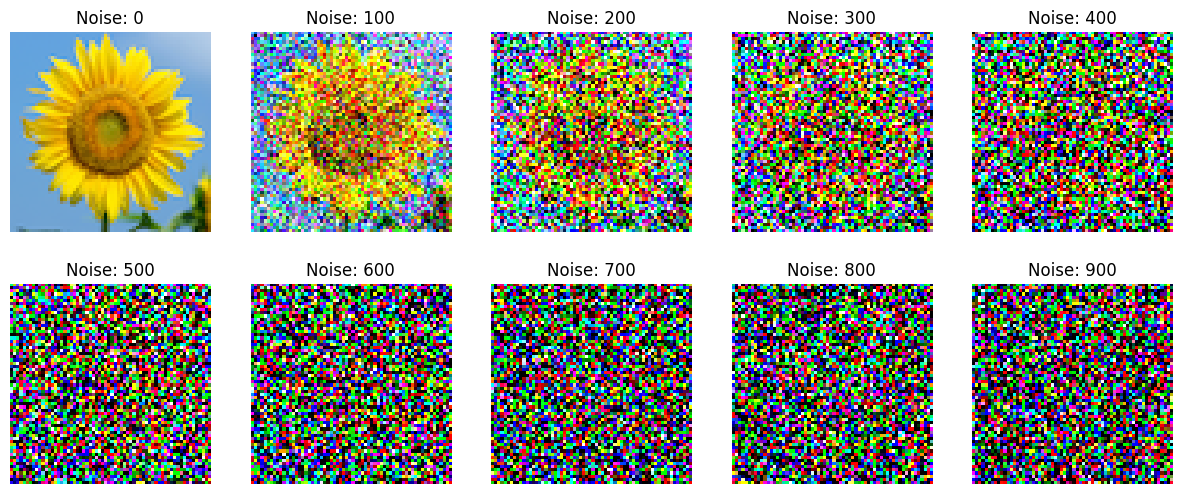

In [15]:
T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
imgs = []

for t in range(T):
    if t % 100 == 0:
        img = reverse_to_image(x)
        imgs.append(img)
    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

plt.figure(figsize=(15, 6))

for i, img in enumerate(imgs[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Noise: {i * 100}')
    plt.axis('off')
plt.show()

#### 반복문으로 하면 느리니까 누적곱을 이용해 q(x_t|x_0)를 한번에 Sampling하기.

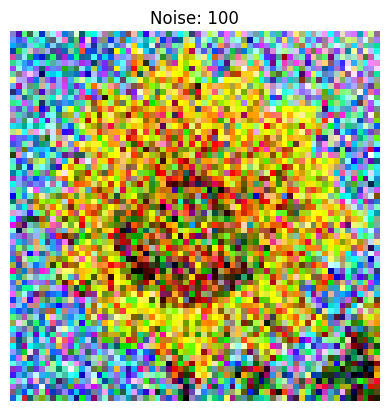

In [16]:
file_path = "./flower.png"
image = plt.imread(file_path)
x = preprocess(image)

T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)

def add_noise(x_0, t, betas):
    T = len(betas)
    assert t >= 1 and t <= T

    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    t_idx = t - 1
    alpha_bar = alpha_bars[t_idx]

    eps = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps

    return x_t

t = 100
x_t = add_noise(x, t, betas)

img = reverse_to_image(x_t)
plt.imshow(img)
plt.title(f'Noise: {t}')
plt.axis('off')
plt.show()

### Diffuser 구현

In [17]:
from tqdm import tqdm

class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device="cpu"):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
    
    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()
        t_idx = t - 1

        alpha_bar = self.alpha_bars[t_idx]
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx - 1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0

        mu = (x - ((1 - alpha) / torch.sqrt(alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1 - alpha) * (1 - alpha_bar_prev) / (1 - alpha_bar))
        return mu + std * noise
    
    def reverse_to_image(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)
    
    def sample(self, model, x_shape=(20, 1, 28, 28)):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t)
        
        images = [self.reverse_to_image(x[i]) for i in range(batch_size)]
        return images


- 공식 및 설명 <- 추가예정

### Train Diffuser

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

img_size = 28
batch_size = 128
num_timesteps=1000
epochs=10
lr=1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"

def show_images(images, rows=2, cols=10):
    plt.clf()
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap="gray")
            plt.axis("off")
            i += 1
    plt.show()

In [27]:
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root="../data", train=True, transform=preprocess, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
diffuser = Diffuser(num_timesteps=num_timesteps, device=device)
model = UNet()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [28]:
losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise_pred, noise)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1
    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f"Epoch: {epoch + 1}, Loss: {loss_avg}")


100%|██████████| 469/469 [00:37<00:00, 12.47it/s]


Epoch: 1, Loss: 0.04594040885647096


100%|██████████| 469/469 [00:35<00:00, 13.10it/s]


Epoch: 2, Loss: 0.026370901705772637


100%|██████████| 469/469 [00:35<00:00, 13.38it/s]


Epoch: 3, Loss: 0.0232270525168699


100%|██████████| 469/469 [00:37<00:00, 12.65it/s]


Epoch: 4, Loss: 0.021737869056477857


100%|██████████| 469/469 [00:34<00:00, 13.45it/s]


Epoch: 5, Loss: 0.020547648288134827


100%|██████████| 469/469 [00:36<00:00, 12.68it/s]


Epoch: 6, Loss: 0.019995542390069475


100%|██████████| 469/469 [00:32<00:00, 14.55it/s]


Epoch: 7, Loss: 0.019132809586394062


100%|██████████| 469/469 [00:31<00:00, 14.72it/s]


Epoch: 8, Loss: 0.019378715893750124


100%|██████████| 469/469 [00:31<00:00, 14.85it/s]


Epoch: 9, Loss: 0.018245751065994378


100%|██████████| 469/469 [00:31<00:00, 14.89it/s]

Epoch: 10, Loss: 0.018163108082214142


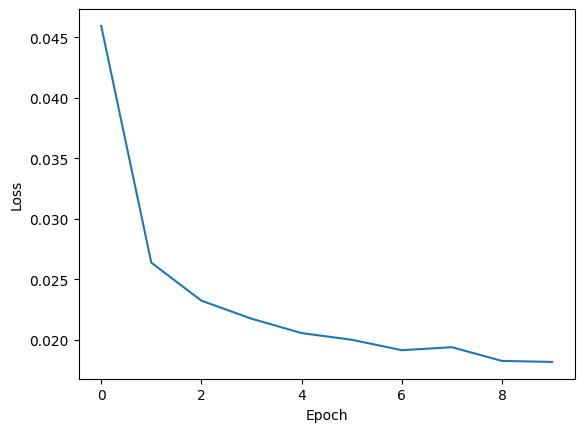

In [29]:
plt.clf()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

100%|██████████| 1000/1000 [00:07<00:00, 141.08it/s]


<Figure size 640x480 with 0 Axes>

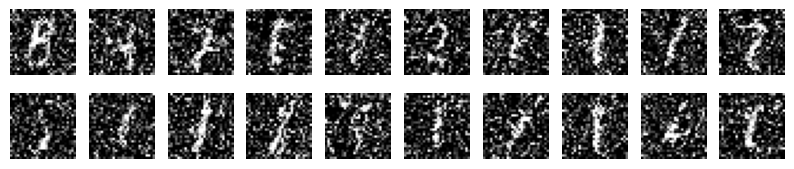

In [30]:
images = diffuser.sample(model)
show_images(images)